# Setting up our Notebook

In [1]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime

# SARIMAX Modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
import statsmodels
import seaborn as sns

# Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.tsa.statespace.exponential_smoothing

# For serialization:
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Importing the Data

In [2]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

# Plotting our Data

In [3]:
# Reading in the data and creating our X and y matrices

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

six_month_date='2021-07-02 11:00:00'

Text(0.5, 1.0, 'BTC Full Data Price')

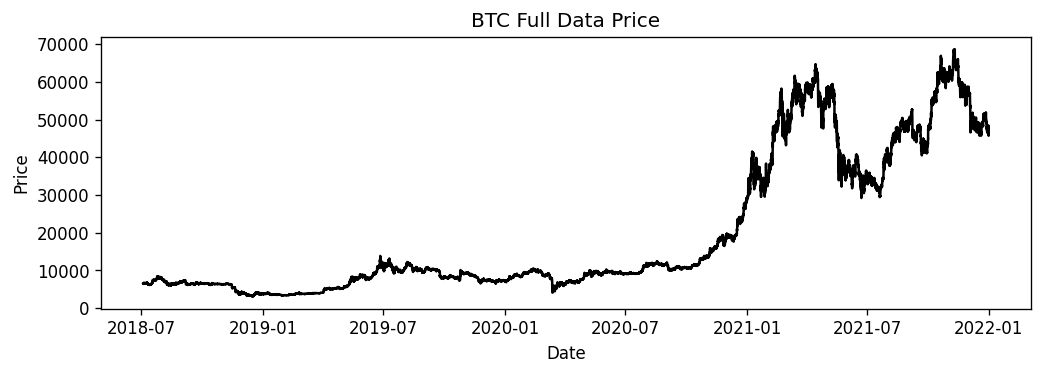

In [70]:
# Plotting our full data

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Close'], color='black')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Full Data Price')

Text(0.5, 1.0, 'BTC Training Price')

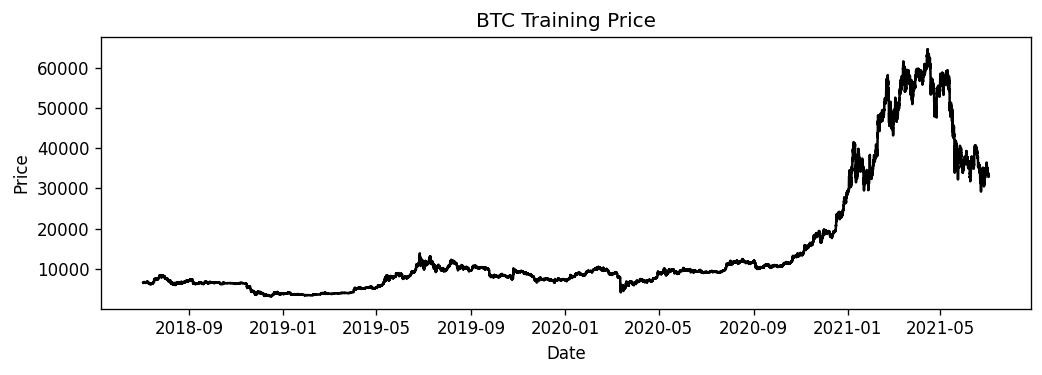

In [67]:
# Plotting our training data

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Close'][:'2021-07-02 11:00:00'], color='black')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Training Price')

Text(0.5, 1.0, 'BTC Testing Price')

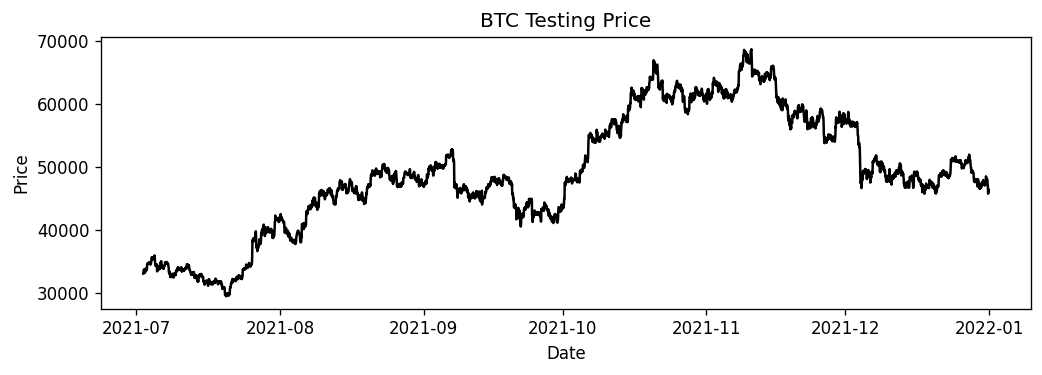

In [68]:
# Plotting our testing data

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Close']['2021-07-02 11:00:00':], color='black')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Testing Price')

# Decomposition, Trend, and Seasonality

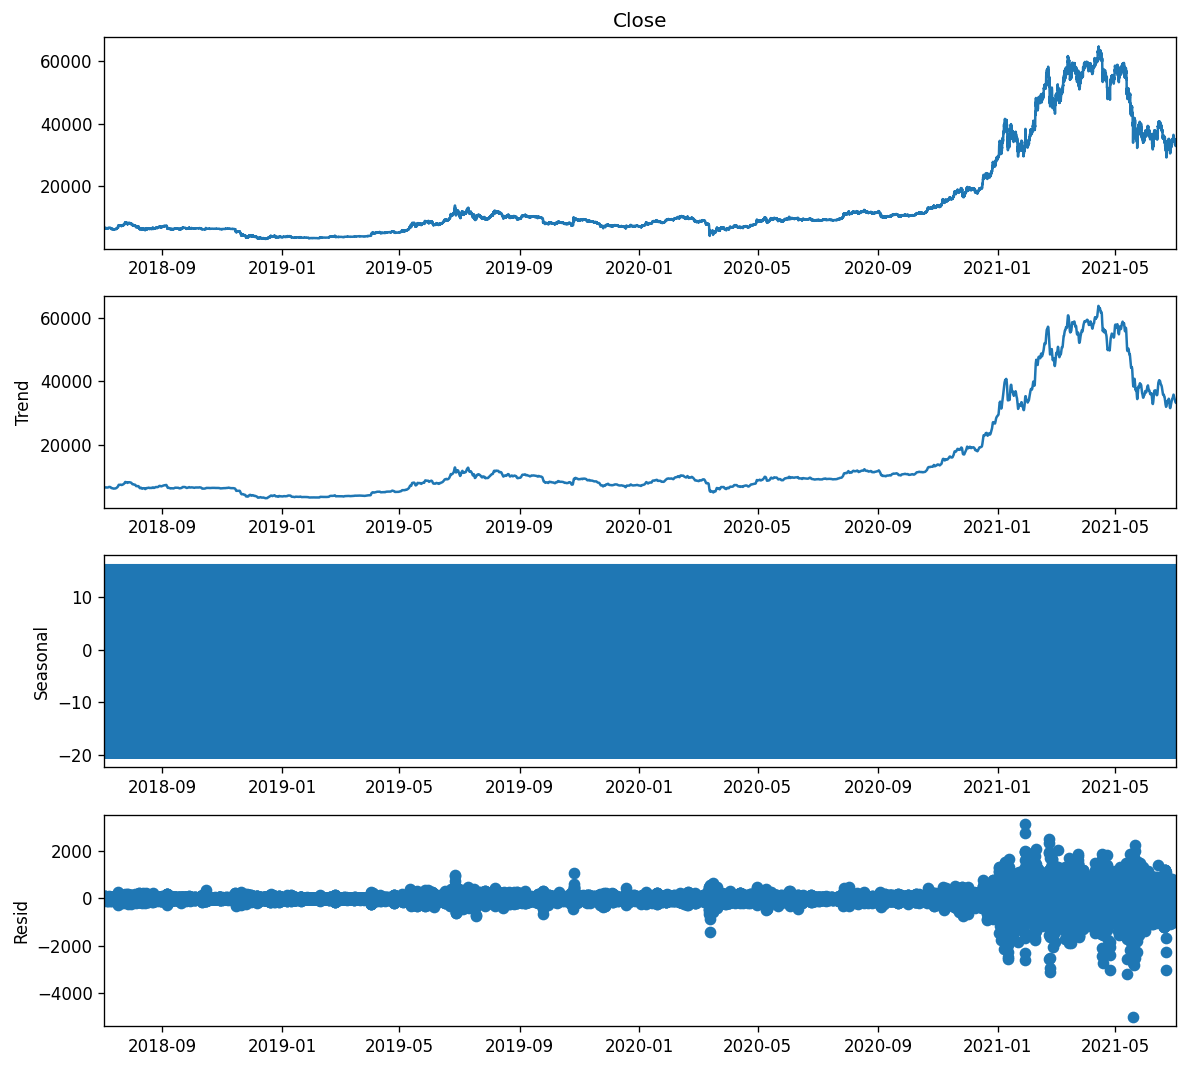

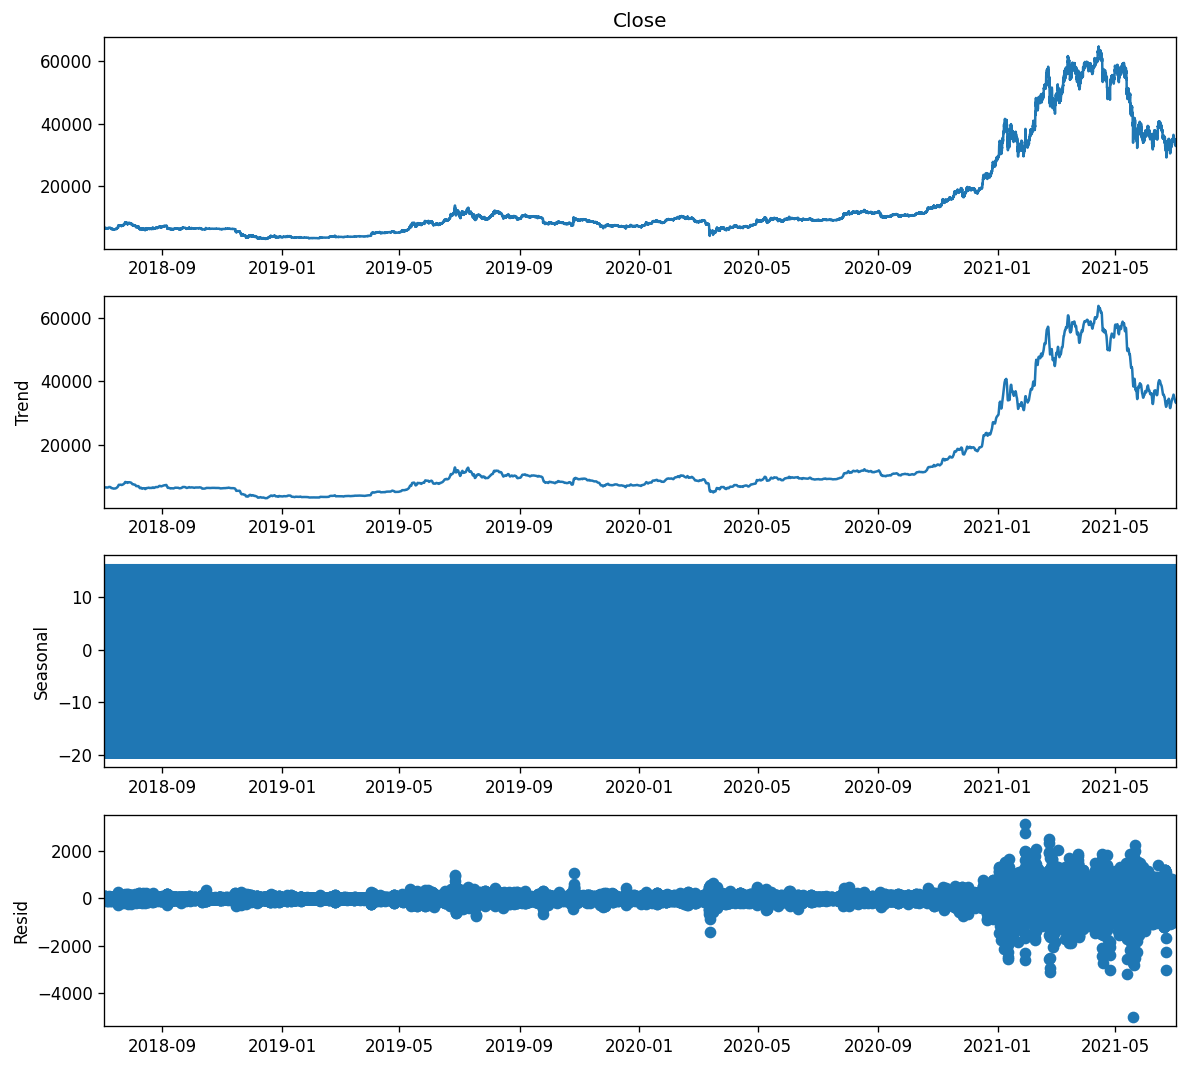

In [7]:
## from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.seasonal

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})

# Additive Decomposition
additive_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(X['Close'][:'2021-07-02 11:00:00'],
                                                                     model='additive')

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

# Multiplicative Decomposition
multiplicative_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(X['Close'][:'2021-07-02 11:00:00'],
                                                                           model='multiplicative')

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

plt.show()

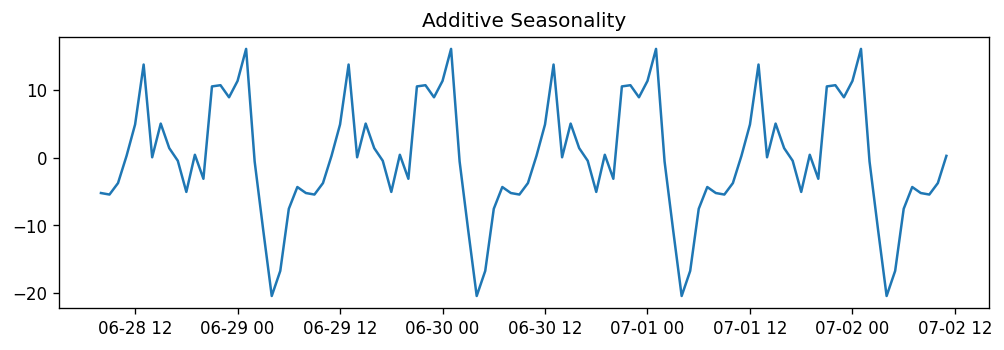

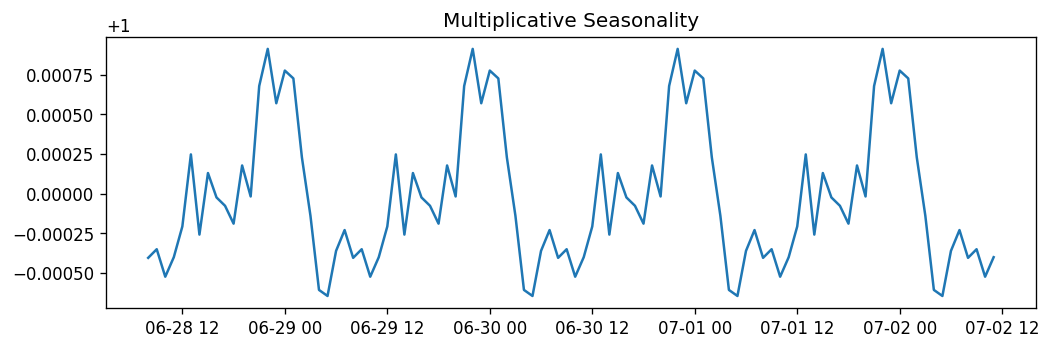

In [8]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
add_season=additive_decomposition.seasonal[-100:]
plt.plot(add_season)
plt.title('Additive Seasonality')
plt.show()

mult_season=multiplicative_decomposition.seasonal[-100:]
plt.plot(mult_season)
plt.title('Multiplicative Seasonality')
plt.show()

We see an obvious trend and seasonality of 24 or so hours, so we will go with a Triple Exponential Smoothing, one with a Trend and Seasonal component

# Exponential Smoothing

From the decompositions, we see an obvious trend and seasonality, justifying our use of the Exponential Smoothing model. A graphic detailing the various iterations of this model follows:

<img src="Graphics/ETS.png" width="600" height="600" />

## Fitting our Models

In [4]:
y=X['Close'][:'2021-07-02 11:00:00']

In [10]:
# Fitting for Trend and Seasonality, where Trend can be Damped or not and Seasonality can be
# Multiplicative or Additive

fit1 = ExponentialSmoothing(
    y,
    seasonal_periods=24,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    y,
    seasonal_periods=24,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit3 = ExponentialSmoothing(
    y,
    seasonal_periods=24,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit4 = ExponentialSmoothing(
    y,
    seasonal_periods=24,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

In [11]:
results

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,9.242857e-01,9.242857e-01,9.242857e-01,9.242858e-01
$\beta$,1.001181e-04,1.001395e-04,1.000193e-04,1.000202e-04
$\phi$,NaN,NaN,9.900000e-01,9.900000e-01
$\gamma$,1.081633e-02,1.081633e-02,1.081633e-02,1.081632e-02
$l_0$,1.903727e+00,1.903727e+00,1.903728e+00,1.903727e+00
$b_0$,-7.629997e-07,-1.924910e-06,2.634638e-07,3.769545e-06
SSE,1.132708e+09,1.132095e+09,1.123685e+09,1.122825e+09


From our Sum of Squared Errors, SSE, we see that the Multiplicative Seasonality with Dampening is the best option.

## Training the best model

In [5]:
# Training a Multiplicative without Dampening model

model=ExponentialSmoothing(
    y,
    seasonal_periods=24,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()

results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Multiplicative"] = [model.params[p] for p in params] + [model.sse]

In [6]:
results

,Multiplicative
$\alpha$,9.242858e-01
$\beta$,1.000202e-04
$\phi$,9.900000e-01
$\gamma$,1.081632e-02
$l_0$,1.903727e+00
$b_0$,3.769545e-06
SSE,1.122825e+09


### Results Visualization

### In-sample Plotting

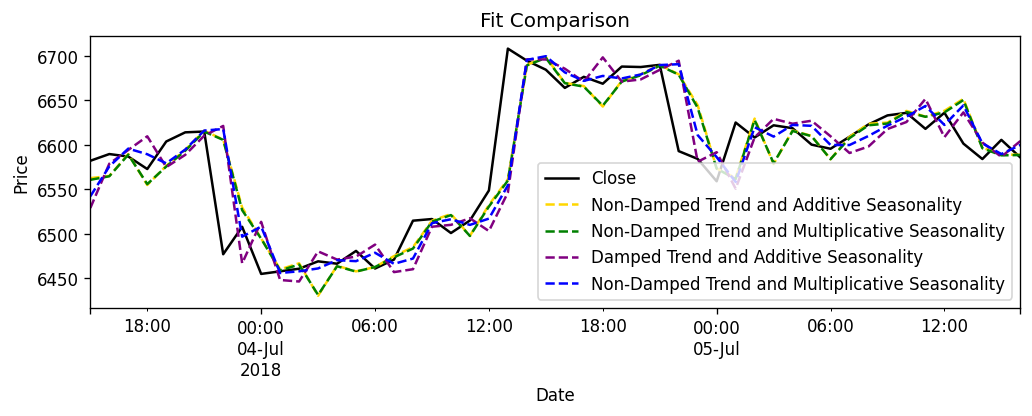

In [61]:
ax = y[:50].plot(
    figsize=(10, 3),
    color="black",
    title="Fit Comparison",
)
ax.set_ylabel('Price')
fit1.fittedvalues[:50].plot(ax=ax, style="--", color="gold", 
                              label='Non-Damped Trend and Additive Seasonality')
fit2.fittedvalues[:50].plot(ax=ax, style="--", color="green", 
                             label='Non-Damped Trend and Multiplicative Seasonality')
fit3.fittedvalues[:50].plot(ax=ax, style="--", color="purple",
                             label='Damped Trend and Additive Seasonality')
fit4.fittedvalues[:50].plot(ax=ax, style="--", color="blue",
                             label='Non-Damped Trend and Multiplicative Seasonality')
plt.legend()

# Forecasting
# fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
#     ax=ax, style="--", marker="o", color="red", legend=True
# )

plt.show()

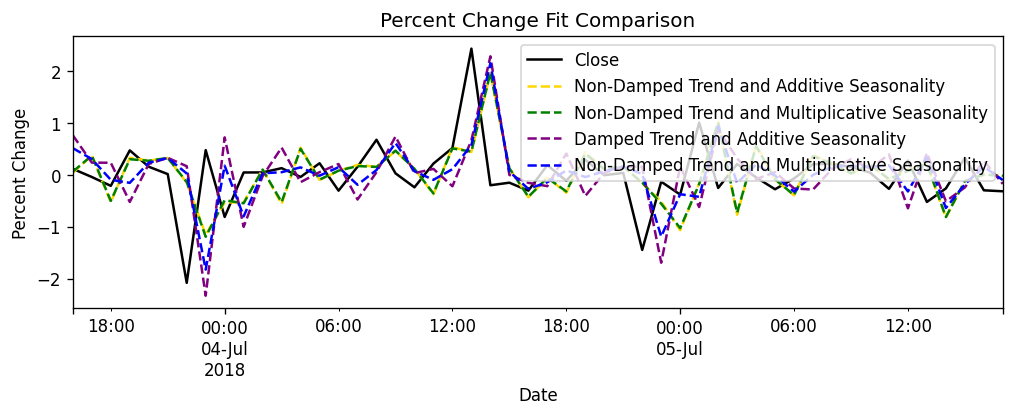

In [62]:
# Plotting the percent change of all the fits

# Getting the percent change of each fit
fit1_pct_change=100*fit1.fittedvalues.pct_change(1)
fit1_pct_change=fit1_pct_change[1:]
fit2_pct_change=100*fit2.fittedvalues.pct_change(1)
fit2_pct_change=fit2_pct_change[1:]
fit3_pct_change=100*fit3.fittedvalues.pct_change(1)
fit3_pct_change=fit3_pct_change[1:]
fit4_pct_change=100*fit4.fittedvalues.pct_change(1)
fit4_pct_change=fit4_pct_change[1:]

# Plotting
y_pct_change=100*y.pct_change(1)
y_pct_change=y_pct_change[1:]

ax =y_pct_change[:50].plot(
    figsize=(10, 3),
    color="black",
    title="Percent Change Fit Comparison",
)
ax.set_ylabel("Percent Change")
fit1_pct_change[:50].plot(ax=ax, style="--", color="gold", 
                              label='Non-Damped Trend and Additive Seasonality')
fit2_pct_change[:50].plot(ax=ax, style="--", color="green", 
                             label='Non-Damped Trend and Multiplicative Seasonality')
fit3_pct_change[:50].plot(ax=ax, style="--", color="purple",
                             label='Damped Trend and Additive Seasonality')
fit4_pct_change[:50].plot(ax=ax, style="--", color="blue",
                             label='Non-Damped Trend and Multiplicative Seasonality')

plt.legend()
plt.show()

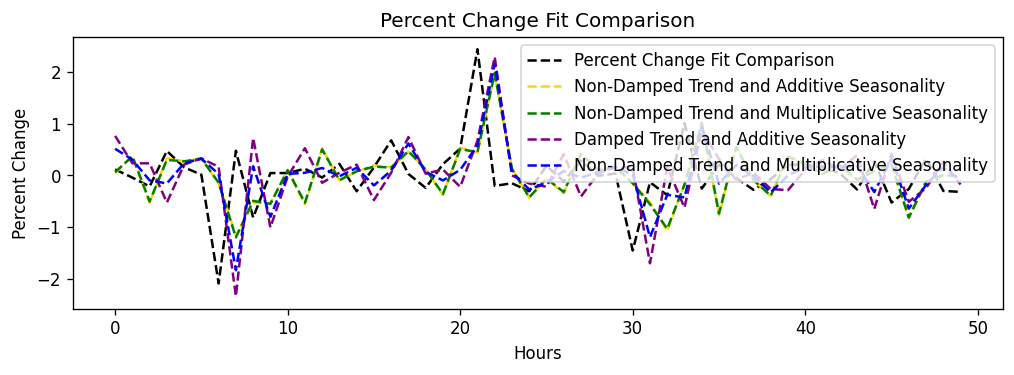

In [63]:
# Getting the percent change of each fit
fit1_pct_change=100*fit1.fittedvalues.pct_change(1)
fit1_pct_change=fit1_pct_change.values[1:]
fit2_pct_change=100*fit2.fittedvalues.pct_change(1)
fit2_pct_change=fit2_pct_change.values[1:]
fit3_pct_change=100*fit3.fittedvalues.pct_change(1)
fit3_pct_change=fit3_pct_change.values[1:]
fit4_pct_change=100*fit4.fittedvalues.pct_change(1)
fit4_pct_change=fit4_pct_change.values[1:]

y_pct_change=100*y.pct_change(1)
y_pct_change=y_pct_change.values[1:]

plt.plot(y_pct_change[:50], color="black", linestyle="--", label="Percent Change Fit Comparison")
plt.plot(fit1_pct_change[:50], color="gold", linestyle="--", label="Non-Damped Trend and Additive Seasonality")
plt.plot(fit2_pct_change[:50], color="green", linestyle="--", label="Non-Damped Trend and Multiplicative Seasonality")
plt.plot(fit3_pct_change[:50], color="purple", linestyle="--", label="Damped Trend and Additive Seasonality")
plt.plot(fit4_pct_change[:50], color="blue", linestyle="--", label="Non-Damped Trend and Multiplicative Seasonality")

plt.title('Percent Change Fit Comparison')
plt.xlabel('Hours')
plt.ylabel('Percent Change')
plt.legend()

### Out-of-sample Plotting

In [7]:
forecast_length=50

y_pred=model.forecast(forecast_length)
y_test=X['Close']['2021-07-02 12:00:00':] # The model will predict the next one, so we want to 
# shift the y_test forward one time step.
print('y_pred head',y_pred.head())
print('y_test head', y_test.head())

y_pred head 2021-07-02 12:00:00    32965.307224
2021-07-02 13:00:00    33013.119289
2021-07-02 14:00:00    32992.467653
2021-07-02 15:00:00    33009.261255
2021-07-02 16:00:00    32989.287618
Freq: H, dtype: float64
y_test head Date
2021-07-02 12:00:00    33231.75
2021-07-02 13:00:00    33500.51
2021-07-02 14:00:00    33669.75
2021-07-02 15:00:00    33689.79
2021-07-02 16:00:00    33634.73
Freq: H, Name: Close, dtype: float64


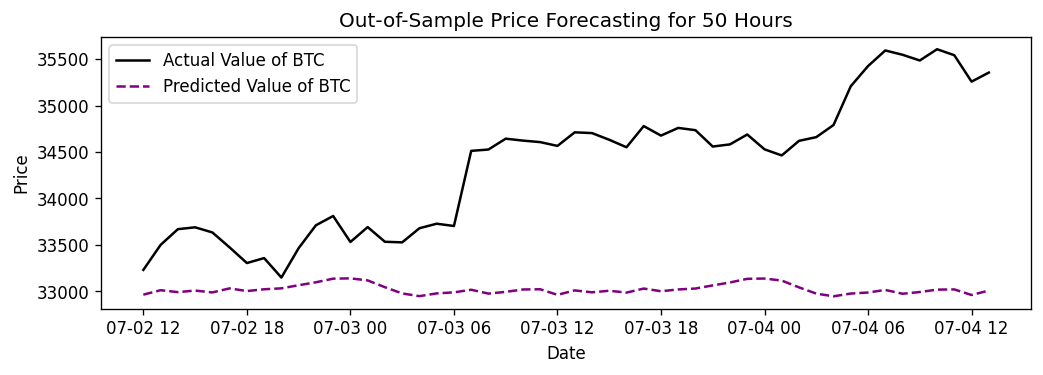

In [8]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(y_test[:forecast_length], label='Actual Value of BTC', color='black')
plt.plot(y_pred, label="Predicted Value of BTC", color='purple', linestyle="--")
plt.title('Out-of-Sample Price Forecasting for 50 Hours')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

Length of our y test percent changes to forecast indices: 49
Length of our y pred percent changes: 49


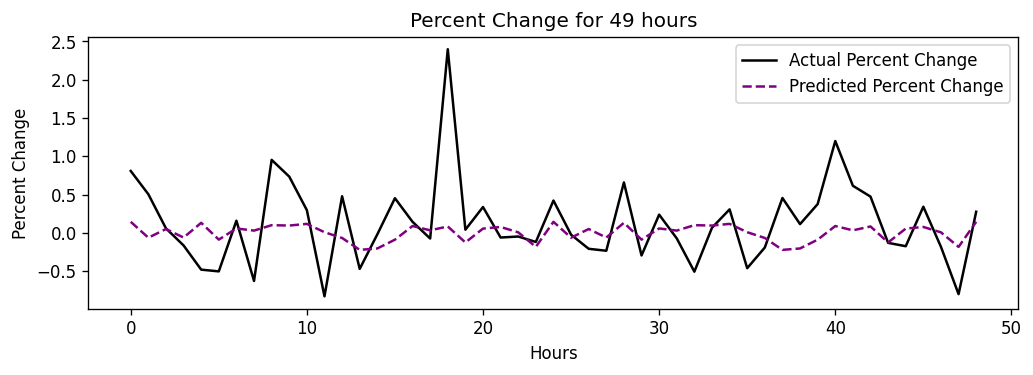

In [9]:
y_pred_pct_changes=y_pred.pct_change(1).values
y_pred_pct_changes=y_pred_pct_changes[1:]
y_test_pct_changes=y_test.pct_change(1).values
y_test_pct_changes=y_test_pct_changes[1:]

print('Length of our y test percent changes to forecast indices:',len(y_test_pct_changes[:forecast_length-1]))
print('Length of our y pred percent changes:',len(y_pred_pct_changes))
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(100*y_test_pct_changes[:forecast_length-1], label='Actual Percent Change', color='black')
plt.plot(100*y_pred_pct_changes, label="Predicted Percent Change", color='purple', linestyle='--')
plt.title('Percent Change for 49 hours')
plt.ylabel("Percent Change")
plt.xlabel("Hours")
plt.legend()

## Saving and Reloading the Model

In [19]:
# Save the model

model.save('Models/BTC 1H ETS.pkl')

In [11]:
# Reload the model

model=statsmodels.tsa.statespace.exponential_smoothing.ExponentialSmoothingResults.load('Models/BTC 1H ETS.pkl')